In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from network.gpv_layers import *
from datasets.datasets_pair import *
from network.sym_v1 import *
from loss.utils import *
from network.utils import *
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
# postnet9d
class FaceRecon_feat(nn.Module):
    def __init__(self, gcn_n_num, gcn_sup_num):
        super(FaceRecon_feat, self).__init__()
        self.neighbor_num = gcn_n_num
        self.support_num = gcn_sup_num

        # 3D convolution for point cloud
        self.conv_0 = Conv_surface(kernel_num=128, support_num=self.support_num)
        self.conv_1 = Conv_layer(128, 128, support_num=self.support_num)
        self.pool_1 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_2 = Conv_layer(128, 256, support_num=self.support_num)
        self.conv_3 = Conv_layer(256, 256, support_num=self.support_num)
        self.pool_2 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_4 = Conv_layer(256, 512, support_num=self.support_num)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)

    def forward(self,
                vertices: "tensor (bs, vetice_num, 3)",
                # cat_id: "tensor (bs, 1)",
                ):
        """
        Return: (bs, vertice_num, class_num)
        """

        neighbor_index = get_neighbor_index(vertices, self.neighbor_num)
        fm_0 = F.relu(self.conv_0(neighbor_index, vertices), inplace=True)

        fm_1 = F.relu(self.bn1(self.conv_1(neighbor_index, vertices, fm_0).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_1, fm_pool_1 = self.pool_1(vertices, fm_1)
        neighbor_index = get_neighbor_index(v_pool_1,
                                                  min(self.neighbor_num, v_pool_1.shape[1] // 8))
        fm_2 = F.relu(self.bn2(self.conv_2(neighbor_index, v_pool_1, fm_pool_1).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        fm_3 = F.relu(self.bn3(self.conv_3(neighbor_index, v_pool_1, fm_2).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_2, fm_pool_2 = self.pool_2(v_pool_1, fm_3)
        neighbor_index = get_neighbor_index(v_pool_2, min(self.neighbor_num,
                                                                v_pool_2.shape[1] // 8))
        fm_4 = self.conv_4(neighbor_index, v_pool_2, fm_pool_2)
        nearest_pool_1 = get_nearest_index(vertices, v_pool_1)
        nearest_pool_2 = get_nearest_index(vertices, v_pool_2)
        fm_2 = indexing_neighbor(fm_2, nearest_pool_1).squeeze(2)
        fm_3 = indexing_neighbor(fm_3, nearest_pool_1).squeeze(2)
        fm_4 = indexing_neighbor(fm_4, nearest_pool_2).squeeze(2)

        feat = torch.cat([fm_0, fm_1, fm_2, fm_3, fm_4], dim=2)
        '''
        feat_face = torch.cat([fm_0, fm_1, fm_2, fm_3, fm_4], dim=2)
        feat_face = torch.mean(feat_face, dim=1, keepdim=True)  # bs x 1 x channel
        feat_face_re = feat_face.repeat(1, feat.shape[1], 1)
        '''
        return feat

class FaceRecon_feat_small(nn.Module):
    def __init__(self, gcn_n_num=10, gcn_sup_num=7):
        super(FaceRecon_feat_small, self).__init__()
        self.neighbor_num = gcn_n_num
        self.support_num = gcn_sup_num

        # 3D convolution for point cloud
        self.conv_0 = Conv_surface(kernel_num=128, support_num=self.support_num)
        self.conv_1 = Conv_layer(128, 128, support_num=self.support_num)
        self.pool_1 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_2 = Conv_layer(128, 256, support_num=self.support_num)
        self.conv_3 = Conv_layer(256, 256, support_num=self.support_num)
        self.pool_2 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_4 = Conv_layer(256, 512, support_num=self.support_num)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)

        # 添加降维层
        self.fc_0 = nn.Linear(128, 32)
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(256, 64)
        self.fc_3 = nn.Linear(256, 64)
        self.fc_4 = nn.Linear(512, 64)

    def forward(self,
                vertices: "tensor (bs, vertice_num, 3)"):
        """
        Return: (bs, vertice_num, class_num)
        """

        neighbor_index = get_neighbor_index(vertices, self.neighbor_num)
        fm_0 = F.relu(self.conv_0(neighbor_index, vertices), inplace=True)

        fm_1 = F.relu(self.bn1(self.conv_1(neighbor_index, vertices, fm_0).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_1, fm_pool_1 = self.pool_1(vertices, fm_1)
        neighbor_index = get_neighbor_index(v_pool_1,
                                            min(self.neighbor_num, v_pool_1.shape[1] // 8))
        fm_2 = F.relu(self.bn2(self.conv_2(neighbor_index, v_pool_1, fm_pool_1).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        fm_3 = F.relu(self.bn3(self.conv_3(neighbor_index, v_pool_1, fm_2).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_2, fm_pool_2 = self.pool_2(v_pool_1, fm_3)
        neighbor_index = get_neighbor_index(v_pool_2, min(self.neighbor_num,
                                                          v_pool_2.shape[1] // 8))
        fm_4 = self.conv_4(neighbor_index, v_pool_2, fm_pool_2)
        nearest_pool_1 = get_nearest_index(vertices, v_pool_1)
        nearest_pool_2 = get_nearest_index(vertices, v_pool_2)
        fm_2 = indexing_neighbor(fm_2, nearest_pool_1).squeeze(2)
        fm_3 = indexing_neighbor(fm_3, nearest_pool_1).squeeze(2)
        fm_4 = indexing_neighbor(fm_4, nearest_pool_2).squeeze(2)

        # 对每个fm进行单独降维
        fm_0 = self.fc_0(fm_0)
        fm_1 = self.fc_1(fm_1)
        fm_2 = self.fc_2(fm_2)
        fm_3 = self.fc_3(fm_3)
        fm_4 = self.fc_4(fm_4)

        feat = torch.cat([fm_0, fm_1, fm_2, fm_3, fm_4], dim=2)
        return feat

class PoseNet9D_Only_R(nn.Module):
    def __init__(self, feat_c_R=1280, R_c=4, gcn_n_num=10, gcn_sup_num=7, face_recon_c=6 * 5, obj_c=6, feat_face=768, feat_c_ts=1289, Ts_c=6):
        super(PoseNet9D_Only_R, self).__init__()
        self.rot_green = Rot_green(feat_c_R, R_c)
        self.rot_red = Rot_red(feat_c_R, R_c)
        self.face_recon = FaceRecon_feat(gcn_n_num, gcn_sup_num)
        # self.ts = Pose_Ts(feat_c_ts, Ts_c)

    def forward(self, points):
        bs, p_num = points.shape[0], points.shape[1]
        feat = self.face_recon(points - points.mean(dim=1, keepdim=True))
        # rotation
        green_R_vec = self.rot_green(feat.permute(0, 2, 1))  # b x 4
        red_R_vec = self.rot_red(feat.permute(0, 2, 1))   # b x 4
        # normalization
        p_green_R = green_R_vec[:, 1:] / (torch.norm(green_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        p_red_R = red_R_vec[:, 1:] / (torch.norm(red_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        # sigmoid for confidence
        f_green_R = F.sigmoid(green_R_vec[:, 0])
        f_red_R = F.sigmoid(red_R_vec[:, 0])
        # translation and size no need
        return p_green_R, p_red_R, f_green_R, f_red_R
    
class PoseNet9D_Only_R_small(nn.Module):
    def __init__(self, feat_c_R=256, R_c=4, gcn_n_num=10, gcn_sup_num=7, face_recon_c=6 * 5, obj_c=6, feat_face=768, feat_c_ts=1289, Ts_c=6):
        super(PoseNet9D_Only_R_small, self).__init__()
        self.rot_green = Rot_green(feat_c_R, R_c)
        self.rot_red = Rot_red(feat_c_R, R_c)
        self.face_recon = FaceRecon_feat_small(gcn_n_num, gcn_sup_num)
        # self.ts = Pose_Ts(feat_c_ts, Ts_c)

    def forward(self, points):
        bs, p_num = points.shape[0], points.shape[1]
        feat = self.face_recon(points - points.mean(dim=1, keepdim=True))
        # rotation
        green_R_vec = self.rot_green(feat.permute(0, 2, 1))  # b x 4
        red_R_vec = self.rot_red(feat.permute(0, 2, 1))   # b x 4
        # normalization
        p_green_R = green_R_vec[:, 1:] / (torch.norm(green_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        p_red_R = red_R_vec[:, 1:] / (torch.norm(red_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        # sigmoid for confidence
        f_green_R = F.sigmoid(green_R_vec[:, 0])
        f_red_R = F.sigmoid(red_R_vec[:, 0])
        # translation and size no need
        return p_green_R, p_red_R, f_green_R, f_red_R
    
# loss
class fs_net_loss_R(nn.Module):
    def __init__(self, loss_type="smoothl1"):
        super(fs_net_loss_R, self).__init__()
        if loss_type == 'l1':
            self.loss_func_t = nn.L1Loss()
            self.loss_func_s = nn.L1Loss()
            self.loss_func_Rot1 = nn.L1Loss()
            self.loss_func_Rot2 = nn.L1Loss()
            self.loss_func_r_con = nn.L1Loss()
            self.loss_func_Recon = nn.L1Loss()
        elif loss_type == 'smoothl1':   # same as MSE
            self.loss_func_t = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_s = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Rot1 = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Rot2 = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_r_con = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Recon = nn.SmoothL1Loss(beta=0.3)
        else:
            raise NotImplementedError

    def forward(self, pred_list, gt_list, sym):
        loss_list = {}

        self.rot_1_w = 1

        loss_list["Rot1"] = self.rot_1_w * self.cal_loss_Rot1(pred_list["Rot1"], gt_list["Rot1"])

        loss_list["Rot2"] = self.rot_1_w * self.cal_loss_Rot2(pred_list["Rot2"], gt_list["Rot2"], sym)

        # loss_list["Recon"] = self.recon_w * self.cal_loss_Recon(pred_list["Recon"], gt_list["Recon"])

        # loss_list["Tran"] = self.tran_w * self.cal_loss_Tran(pred_list["Tran"], gt_list["Tran"])
    
        # loss_list["Size"] = self.size_w * self.cal_loss_Size(pred_list["Size"], gt_list["Size"])

        return loss_list

    def cal_loss_Rot1(self, pred_v, gt_v):
        bs = pred_v.shape[0]
        res = torch.zeros([bs], dtype=torch.float32, device=pred_v.device)
        for i in range(bs):
            pred_v_now = pred_v[i, ...]
            gt_v_now = gt_v[i, ...]
            res[i] = self.loss_func_Rot1(pred_v_now, gt_v_now)
        res = torch.mean(res)
        return res

    def cal_loss_Rot2(self, pred_v, gt_v, sym):
        bs = pred_v.shape[0]
        res = 0.0
        valid = 0.0
        for i in range(bs):
            sym_now = sym[i, 0]
            if sym_now == 1:
                continue
            else:
                pred_v_now = pred_v[i, ...]
                gt_v_now = gt_v[i, ...]
                res += self.loss_func_Rot2(pred_v_now, gt_v_now)
                valid += 1.0
        if valid > 0.0:
            res = res / valid
        return res

    def cal_loss_Recon(self, pred_recon, gt_recon):
        return self.loss_func_Recon(pred_recon, gt_recon)

    def cal_loss_Tran(self, pred_trans, gt_trans):
        return self.loss_func_t(pred_trans, gt_trans)

    def cal_loss_Size(self, pred_size, gt_size):
        return self.loss_func_s(pred_size, gt_size)
    
class fs_net_loss_full(nn.Module):
    def __init__(self, fsnet_loss_type="smoothl1", rot_1_w=8.0, rot_2_w=8.0, rot_regular=4.0, recon_w=8.0, tran_w=8.0, size_w=8.0, r_con_w=1.0):
        super(fs_net_loss_full, self).__init__()
        self.fsnet_loss_type = fsnet_loss_type
        self.rot_1_w = rot_1_w
        self.rot_2_w = rot_2_w
        self.rot_regular = rot_regular
        self.recon_w = recon_w
        self.tran_w = tran_w
        self.size_w = size_w
        self.r_con_w = r_con_w
        if self.fsnet_loss_type == 'l1':
            self.loss_func_t = nn.L1Loss()
            self.loss_func_s = nn.L1Loss()
            self.loss_func_Rot1 = nn.L1Loss()
            self.loss_func_Rot2 = nn.L1Loss()
            self.loss_func_r_con = nn.L1Loss()
            self.loss_func_Recon = nn.L1Loss()
        elif self.fsnet_loss_type == 'smoothl1':   # same as MSE
            self.loss_func_t = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_s = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Rot1 = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Rot2 = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_r_con = nn.SmoothL1Loss(beta=0.5)
            self.loss_func_Recon = nn.SmoothL1Loss(beta=0.3)
        else:
            raise NotImplementedError

    def forward(self, name_list, pred_list, gt_list, sym):
        loss_list = {}
        if "Rot1" in name_list:
            loss_list["Rot1"] = self.rot_1_w * self.cal_loss_Rot1(pred_list["Rot1"], gt_list["Rot1"])

        if "Rot1_cos" in name_list:
            loss_list["Rot1_cos"] = self.rot_1_w * self.cal_cosine_dis(pred_list["Rot1"], gt_list["Rot1"])

        if "Rot2" in name_list:
            loss_list["Rot2"] = self.rot_2_w * self.cal_loss_Rot2(pred_list["Rot2"], gt_list["Rot2"], sym)

        if "Rot2_cos" in name_list:
            loss_list["Rot2_cos"] = self.rot_2_w * self.cal_cosine_dis_sym(pred_list["Rot2"], gt_list["Rot2"], sym)

        if "Rot_regular" in name_list:
            loss_list["Rot_r_a"] = self.rot_regular * self.cal_rot_regular_angle(pred_list["Rot1"],
                                                                                  pred_list["Rot2"], sym)

        if "Recon" in name_list:
            loss_list["Recon"] = self.recon_w * self.cal_loss_Recon(pred_list["Recon"], gt_list["Recon"])

        if "Tran" in name_list:
            loss_list["Tran"] = self.tran_w * self.cal_loss_Tran(pred_list["Tran"], gt_list["Tran"])

        if "Size" in name_list:
            loss_list["Size"] = self.size_w * self.cal_loss_Size(pred_list["Size"], gt_list["Size"])

        if "R_con" in name_list:
            loss_list["R_con"] = self.r_con_w * self.cal_loss_R_con(pred_list["Rot1"], pred_list["Rot2"],
                                                                     gt_list["Rot1"], gt_list["Rot2"],
                                                                     pred_list["Rot1_f"], pred_list["Rot2_f"], sym)
        return loss_list

    def cal_loss_R_con(self, p_rot_g, p_rot_r, g_rot_g, g_rot_r, p_g_con, p_r_con, sym):
        dis_g = p_rot_g - g_rot_g    # bs x 3
        dis_g_norm = torch.norm(dis_g, dim=-1)   # bs
        p_g_con_gt = torch.exp(-13.7 * dis_g_norm * dis_g_norm)  # bs
        res_g = self.loss_func_r_con(p_g_con_gt, p_g_con)
        res_r = 0.0
        bs = p_rot_g.shape[0]
        for i in range(bs):
            if sym[i, 0] == 0:
                dis_r = p_rot_r[i, ...] - g_rot_r[i, ...]
                dis_r_norm = torch.norm(dis_r)   # 1
                p_r_con_gt = torch.exp(-13.7 * dis_r_norm * dis_r_norm)
                res_r += self.loss_func_r_con(p_r_con_gt, p_r_con[i])
        res_r = res_r / bs
        return res_g + res_r


    def cal_loss_Rot1(self, pred_v, gt_v):
        bs = pred_v.shape[0]
        res = torch.zeros([bs], dtype=torch.float32, device=pred_v.device)
        for i in range(bs):
            pred_v_now = pred_v[i, ...]
            gt_v_now = gt_v[i, ...]
            res[i] = self.loss_func_Rot1(pred_v_now, gt_v_now)
        res = torch.mean(res)
        return res

    def cal_loss_Rot2(self, pred_v, gt_v, sym):
        bs = pred_v.shape[0]
        res = 0.0
        valid = 0.0
        for i in range(bs):
            sym_now = sym[i, 0]
            if sym_now == 1:
                continue
            else:
                pred_v_now = pred_v[i, ...]
                gt_v_now = gt_v[i, ...]
                res += self.loss_func_Rot2(pred_v_now, gt_v_now)
                valid += 1.0
        if valid > 0.0:
            res = res / valid
        return res

    def cal_cosine_dis(self, pred_v, gt_v):
        # pred_v  bs x 6, gt_v bs x 6
        bs = pred_v.shape[0]
        res = torch.zeros([bs], dtype=torch.float32).to(pred_v.device)
        for i in range(bs):
            pred_v_now = pred_v[i, ...]
            gt_v_now = gt_v[i, ...]
            res[i] = (1.0 - torch.sum(pred_v_now * gt_v_now)) * 2.0
        res = torch.mean(res)
        return res

    def cal_cosine_dis_sym(self, pred_v, gt_v, sym):
        # pred_v  bs x 6, gt_v bs x 6
        bs = pred_v.shape[0]
        res = 0.0
        valid = 0.0
        for i in range(bs):
            sym_now = sym[i, 0]
            if sym_now == 1:
                continue
            else:
                pred_v_now = pred_v[i, ...]
                gt_v_now = gt_v[i, ...]
                res += (1.0 - torch.sum(pred_v_now * gt_v_now)) * 2.0
                valid += 1.0
        if valid > 0.0:
            res = res / valid
        return res


    def cal_rot_regular_angle(self, pred_v1, pred_v2, sym):
        bs = pred_v1.shape[0]
        res = 0.0
        valid = 0.0
        for i in range(bs):
            if sym[i, 0] == 1:
                continue
            y_direction = pred_v1[i, ...]
            z_direction = pred_v2[i, ...]
            residual = torch.dot(y_direction, z_direction)
            res += torch.abs(residual)
            valid += 1.0
        if valid > 0.0:
            res = res / valid
        return res

    def cal_loss_Recon(self, pred_recon, gt_recon):
        return self.loss_func_Recon(pred_recon, gt_recon)

    def cal_loss_Tran(self, pred_trans, gt_trans):
        return self.loss_func_t(pred_trans, gt_trans)

    def cal_loss_Size(self, pred_size, gt_size):
        return self.loss_func_s(pred_size, gt_size)



In [2]:
root_dir = "/16T/zhangran/GAPartNet_re_rendered/train"
test_intra_dir = "/16T/zhangran/GAPartNet_re_rendered/test_intra"
test_inter_dir = "/16T/zhangran/GAPartNet_re_rendered/test_inter"
def get_datasets(root_dir, test_intra_dir, test_inter_dir, max_points=2000, voxelization=False, shot=False, choose_category: List=None, augmentation=True):
    if shot:
        few_shot = True
        few_shot_num = 20
    else:
        few_shot = False
        few_shot_num = None

    dataset_train = GAPartNetPair(
        Path(root_dir) / "pth",
        Path(root_dir) / "meta",
        shuffle=True,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    dataset_test_intra = GAPartNetPair(
        Path(test_intra_dir) / "pth",
        Path(test_intra_dir) / "meta",
        shuffle=False,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    dataset_test_inter = GAPartNetPair(
        Path(test_inter_dir) / "pth",
        Path(test_inter_dir) / "meta",
        shuffle=False,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    return dataset_train, dataset_test_intra, dataset_test_inter

def get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, batch_size=16, num_workers=8):
    dataloader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False
    )
    # test_intra_sampler = DistributedSampler(dataset_test_intra, shuffle=False)
    dataloader_test_intra = DataLoader(
        dataset_test_intra,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False,
        # sampler=test_intra_sampler
    )
    # test_inter_sampler = DistributedSampler(dataset_test_inter, shuffle=False)
    dataloader_test_inter = DataLoader(
        dataset_test_inter,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False,
        # sampler=test_inter_sampler
    )
    return dataloader_train, dataloader_test_intra, dataloader_test_inter

In [3]:
class test_GPV(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = PoseNet9D_Only_R(feat_c_R=1280)
    
    def forward(self, pc_list: List[PointCloudPair]):
        points1 = torch.cat([pc.pc1.points.unsqueeze(0) for pc in pc_list], dim=0)  # pc_list is batch size
        points2 = torch.cat([pc.pc2.points.unsqueeze(0) for pc in pc_list], dim=0)
        p_green_R1, p_red_R1, f_green_R1, f_red_R1 = self.backbone(points1[:, :, 0:3])
        p_green_R2, p_red_R2, f_green_R2, f_red_R2 = self.backbone(points2[:, :, 0:3])
        return (p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2)

def train(model: test_GPV, dataloader_train, dataloader_test_inter, dataloader_test_intra, lr, num_epochs, log_dir):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = fs_net_loss_full()
    name_list = ['Rot1', 'Rot2', 'Rot1_cos', 'Rot2_cos', 'Rot_regular']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # model = DataParallel(model)
    model.train()
    log_dir = log_dir + "/" + str(datetime.today())
    writer = SummaryWriter(log_dir=log_dir)

    global_step = 0
    print("_________________________train_epoch___________________________")
    for epoch in range(num_epochs):
        total_loss = 0
        if epoch == 0:
            # first test epoch
            print("______________________first_test_epoch_________________________")
            torch.save(model.state_dict(), log_dir+r'/'+f"GPV_[{epoch+1}|{num_epochs}].pth")
            # test_metrics(model, dataloader_test_inter, device, writer, epoch, 'test_inter')
            test_metrics(model, dataloader_test_intra, device, writer, epoch, 'test_intra')
        for batch_idx, batch in enumerate(dataloader_train):
            pc_pairs = [pair.to(device) for pair in batch]
            optimizer.zero_grad()

            (p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2) = model(pc_pairs)
            
            # Assuming we have ground truth rotations
            R_green_gt1, R_red_gt1 = get_gt_v(ground_truth_rotations([pc.rot_1.T for pc in pc_pairs]))  # Function to get ground truth rotation vectors
            R_green_gt2, R_red_gt2 = get_gt_v(ground_truth_rotations([pc.rot_2.T for pc in pc_pairs]))  # Function to get ground truth rotation vectors
            
            pred_list1 = {
                "Rot1": p_green_R1,
                "Rot2": p_red_R1,
            }
            gt_list1 = {
                "Rot1": R_green_gt1.cuda(),
                "Rot2": R_red_gt1.cuda(),
            }
            
            pred_list2 = {
                "Rot1": p_green_R2,
                "Rot2": p_red_R2,
            }
            gt_list2 = {
                "Rot1": R_green_gt2.cuda(),
                "Rot2": R_red_gt2.cuda(),
            }

            sym1, sym2 = get_sym_from_input(pc_pairs)

            loss_dict1 = criterion(name_list, pred_list1, gt_list1, sym1)
            loss_dict2 = criterion(name_list, pred_list2, gt_list2, sym2)
            loss = (sum(loss_dict1.values()) + sum(loss_dict2.values())) / 2
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            global_step += 1

            # 每10个batch记录一次loss
            if (batch_idx + 1) % 10 == 0:
                writer.add_scalar('train/loss', loss.item(), global_step)
                print(f"Epoch:[{epoch + 1}|{num_epochs}],Batch:[{(batch_idx + 1)}|{len(dataloader_train)}],Loss:[{loss.item():.4f}]")

        avg_loss = total_loss / len(dataloader_train)
        print(f"Epoch [{epoch+1}|{num_epochs}],Loss:{avg_loss:.4f}")
        writer.add_scalar('train/avg_loss', avg_loss, epoch)

        # 每5个epoch跑一次测试集
        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), log_dir+r'/'+f"GPV_[{epoch+1}|{num_epochs}].pth")
            # test_metrics(model, dataloader_test_inter, device, writer, epoch, 'test_inter')
            test_metrics(model, dataloader_test_intra, device, writer, epoch, 'test_intra')
            test_metrics(model, dataloader_train, device, writer, epoch, 'test_train')


def test_metrics(model, dataloader, device, writer, epoch, phase):
    print("______________________" + phase + "_______________________")
    model.eval()
    all_pred_rot_matrices = []
    all_gt_rot_matrices = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            pc_pairs = [pair.to(device) for pair in batch]
            (p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2) = model(pc_pairs)
            
            # Assuming we have ground truth rotations
            R_green_gt1, R_red_gt1 = get_gt_v(ground_truth_rotations([pc.rot_1.T for pc in pc_pairs]))  # Function to get ground truth rotation vectors
            R_green_gt2, R_red_gt2 = get_gt_v(ground_truth_rotations([pc.rot_2.T for pc in pc_pairs]))  # Function to get ground truth rotation vectors
            
            # Convert predicted vectors and ground truth vectors back to rotation matrices
            pred_rot_matrices1 = vectors_to_rotation_matrix(p_green_R1, p_red_R1, True)
            pred_rot_matrices2 = vectors_to_rotation_matrix(p_green_R2, p_red_R2, True)
            gt_rot_matrices1 = vectors_to_rotation_matrix(R_green_gt1, R_red_gt1, True)
            gt_rot_matrices2 = vectors_to_rotation_matrix(R_green_gt2, R_red_gt2, True)
            
            # Store predictions and ground truths for metrics calculation
            all_pred_rot_matrices.append(pred_rot_matrices1.cpu())
            all_pred_rot_matrices.append(pred_rot_matrices2.cpu())
            all_gt_rot_matrices.append(gt_rot_matrices1.cpu())
            all_gt_rot_matrices.append(gt_rot_matrices2.cpu())
    
    all_pred_rot_matrices = torch.cat(all_pred_rot_matrices, dim=0)
    all_gt_rot_matrices = torch.cat(all_gt_rot_matrices, dim=0)

    mean_rot_error = calculate_pose_metrics(
        all_pred_rot_matrices, all_gt_rot_matrices
    )
    if writer is not None:
        writer.add_scalar(f'{phase}/mean_rot_error', mean_rot_error, epoch)
    print(f"{phase} - Epoch [{epoch+1}]: Mean Rotation Error: {mean_rot_error:.4f}")
    model.train()

In [4]:
model = test_GPV().cuda()
model.load_state_dict(torch.load("log_dir/GPV_test_new_loss/2024-06-09 13:38:03.887472/GPV_[100|100].pth"))
dataset_train, dataset_test_intra, dataset_test_inter = get_datasets(root_dir, test_intra_dir, test_inter_dir, voxelization=False, shot=True, choose_category=None, max_points=2048, augmentation=False)
dataloader_train, dataloader_test_intra, dataloader_test_inter = get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, num_workers=0, batch_size=16)
# train(model, dataloader_train, dataloader_test_inter, dataloader_test_intra, 0.0001, 300, "./log_dir/GPV_test_new_loss_cat_Camera")
# print(len(dataset_train),",",len(dataset_test_intra),',',len(dataset_test_inter))

In [7]:
train(model, dataloader_train, dataloader_test_inter, dataloader_test_intra, 0.0001, 100, "./log_dir/tmp_for_debug")

_________________________train_epoch___________________________
______________________first_test_epoch_________________________
______________________test_intra_______________________


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


test_intra - Epoch [1]: Mean Rotation Error: 47.5372
Epoch [1|100],Loss:0.4390
Epoch [2|100],Loss:0.8947
Epoch [3|100],Loss:0.8581
Epoch [4|100],Loss:0.6595
Epoch [5|100],Loss:0.5131
Epoch [6|100],Loss:0.6660
Epoch [7|100],Loss:0.6224
Epoch [8|100],Loss:0.5634
Epoch [9|100],Loss:0.5473
Epoch [10|100],Loss:0.6065
Epoch [11|100],Loss:0.5639
Epoch [12|100],Loss:0.4555
Epoch [13|100],Loss:0.6976
Epoch [14|100],Loss:0.5069
Epoch [15|100],Loss:0.6387
Epoch [16|100],Loss:0.5313
Epoch [17|100],Loss:0.6545
Epoch [18|100],Loss:0.6341
Epoch [19|100],Loss:0.4640
Epoch [20|100],Loss:0.6731
______________________test_intra_______________________


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


test_intra - Epoch [20]: Mean Rotation Error: 52.0607
______________________test_train_______________________


100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


test_train - Epoch [20]: Mean Rotation Error: 24.9083
Epoch [21|100],Loss:0.5197
Epoch [22|100],Loss:0.5669
Epoch [23|100],Loss:0.4753
Epoch [24|100],Loss:0.6187
Epoch [25|100],Loss:0.7327
Epoch [26|100],Loss:0.5165
Epoch [27|100],Loss:0.5860
Epoch [28|100],Loss:0.6429
Epoch [29|100],Loss:0.4985
Epoch [30|100],Loss:0.5183
Epoch [31|100],Loss:0.6236
Epoch [32|100],Loss:0.4674
Epoch [33|100],Loss:0.6608
Epoch [34|100],Loss:0.7618
Epoch [35|100],Loss:0.5981
Epoch [36|100],Loss:0.6337
Epoch [37|100],Loss:0.3652
Epoch [38|100],Loss:0.5301
Epoch [39|100],Loss:0.7611
Epoch [40|100],Loss:0.4867
______________________test_intra_______________________


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


test_intra - Epoch [40]: Mean Rotation Error: 52.1732
______________________test_train_______________________


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


test_train - Epoch [40]: Mean Rotation Error: 25.7835
Epoch [41|100],Loss:0.6251
Epoch [42|100],Loss:0.3881
Epoch [43|100],Loss:0.5691
Epoch [44|100],Loss:0.5494
Epoch [45|100],Loss:0.5548
Epoch [46|100],Loss:0.3882
Epoch [47|100],Loss:0.4519
Epoch [48|100],Loss:0.5175
Epoch [49|100],Loss:0.5338
Epoch [50|100],Loss:0.5476
Epoch [51|100],Loss:0.7880
Epoch [52|100],Loss:0.6421
Epoch [53|100],Loss:0.4149
Epoch [54|100],Loss:0.5515
Epoch [55|100],Loss:0.5598
Epoch [56|100],Loss:0.6216
Epoch [57|100],Loss:0.6129
Epoch [58|100],Loss:0.6423
Epoch [59|100],Loss:0.5167
Epoch [60|100],Loss:0.5834
______________________test_intra_______________________


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


test_intra - Epoch [60]: Mean Rotation Error: 53.8511
______________________test_train_______________________


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


test_train - Epoch [60]: Mean Rotation Error: 18.6405
Epoch [61|100],Loss:0.4995
Epoch [62|100],Loss:0.4396
Epoch [63|100],Loss:0.5930
Epoch [64|100],Loss:0.5892
Epoch [65|100],Loss:0.6324
Epoch [66|100],Loss:0.4864
Epoch [67|100],Loss:0.5504
Epoch [68|100],Loss:0.5358
Epoch [69|100],Loss:0.6069
Epoch [70|100],Loss:0.5433
Epoch [71|100],Loss:0.4676
Epoch [72|100],Loss:0.4784
Epoch [73|100],Loss:0.4368
Epoch [74|100],Loss:0.5197
Epoch [75|100],Loss:0.3988
Epoch [76|100],Loss:0.5159
Epoch [77|100],Loss:0.4895
Epoch [78|100],Loss:0.3659
Epoch [79|100],Loss:0.4712
Epoch [80|100],Loss:0.4606
______________________test_intra_______________________


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


test_intra - Epoch [80]: Mean Rotation Error: 54.1466
______________________test_train_______________________


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


test_train - Epoch [80]: Mean Rotation Error: 23.6748
Epoch [81|100],Loss:0.4177
Epoch [82|100],Loss:0.4561
Epoch [83|100],Loss:0.6123
Epoch [84|100],Loss:0.5005
Epoch [85|100],Loss:0.4572
Epoch [86|100],Loss:0.3845
Epoch [87|100],Loss:0.5828
Epoch [88|100],Loss:0.5757
Epoch [89|100],Loss:0.3776
Epoch [90|100],Loss:0.5129
Epoch [91|100],Loss:0.5119
Epoch [92|100],Loss:0.5264
Epoch [93|100],Loss:0.5041
Epoch [94|100],Loss:0.4882
Epoch [95|100],Loss:0.3804
Epoch [96|100],Loss:0.5029
Epoch [97|100],Loss:0.4736
Epoch [98|100],Loss:0.4573
Epoch [99|100],Loss:0.4072
Epoch [100|100],Loss:0.4211
______________________test_intra_______________________


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


test_intra - Epoch [100]: Mean Rotation Error: 49.0961
______________________test_train_______________________


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

test_train - Epoch [100]: Mean Rotation Error: 20.7943


In [5]:
import visu.utils as u
import importlib
importlib.reload(u)
model.cuda()
test_metrics(model, dataloader_train, "cuda:0", None, 299, "train")
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
model.cpu()
datasets = [dataset_train, dataset_test_inter, dataset_test_intra]
u.random_check_pair(model, datasets, dir_name, log_name, transpose=True)

______________________train_______________________


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


train - Epoch [300]: Mean Rotation Error: 3.6615
index:  14
datasets:  /16T/zhangran/GAPartNet_re_rendered/train
Remote_101117_0_24  and  Remote_101117_0_25
rot1:  tensor([[[-0.7327, -0.6886, -0.0210],
         [-0.4711,  0.5237, -0.7057],
         [ 0.4912, -0.5016, -0.7081]]])
gt1:  tensor([[[-6.9341e-01, -7.2054e-01, -5.9605e-08],
         [-4.8950e-01,  4.7107e-01, -7.3381e-01],
         [ 5.2874e-01, -5.0883e-01, -6.7936e-01]]])
vectors1:  tensor([[-0.6886,  0.5237, -0.5016]]) tensor([[-0.7327, -0.4711,  0.4912]])
vectors_gt1:  tensor([[-0.7205,  0.4711, -0.5088]]) tensor([[-0.6934, -0.4895,  0.5287]])
error1:  1.9919780934540938
error_gt:  0.0
rot2:  tensor([[[ 0.3757, -0.9187, -0.0698],
         [-0.3795, -0.0901, -0.9212],
         [ 0.8455,  0.3845, -0.3825]]])
gt2:  tensor([[[ 0.2834, -0.9590,  0.0000],
         [-0.3401, -0.1005, -0.9350],
         [ 0.8967,  0.2650, -0.3546]]])
vectors2:  tensor([[-0.9187, -0.0901,  0.3845]]) tensor([[ 0.3757, -0.3795,  0.8455]])
vectors_gt

In [11]:
# print(model.backbone.rot_green.conv1.weight)
# print(torch.load("log_dir/tmp_for_debug/2024-07-07 19:50:48.859964/GPV_[100|100].pth")['backbone.rot_green.conv1.weight'])
model.load_state_dict()

Parameter containing:
tensor([[[-0.0078],
         [-0.0104],
         [ 0.0020],
         ...,
         [-0.0172],
         [-0.0091],
         [-0.0192]],

        [[ 0.0046],
         [ 0.0233],
         [-0.0146],
         ...,
         [ 0.0111],
         [ 0.0054],
         [ 0.0183]],

        [[ 0.0072],
         [-0.0011],
         [ 0.0121],
         ...,
         [-0.0265],
         [-0.0167],
         [-0.0097]],

        ...,

        [[-0.0250],
         [-0.0053],
         [ 0.0244],
         ...,
         [ 0.0038],
         [-0.0139],
         [-0.0034]],

        [[ 0.0133],
         [-0.0220],
         [-0.0263],
         ...,
         [-0.0180],
         [ 0.0136],
         [-0.0031]],

        [[ 0.0187],
         [ 0.0273],
         [ 0.0125],
         ...,
         [ 0.0142],
         [-0.0279],
         [-0.0083]]], device='cuda:0', requires_grad=True)
tensor([[[-0.0078],
         [-0.0104],
         [ 0.0020],
         ...,
         [-0.0172],
         [-0.0091

In [9]:
# get first axis and the other axis. 
rotation_gt = np.array([
    0.6342804431915283,
    -0.18115395307540894,
    0.7515794038772583,
    -0.7731031179428101,
    -0.14862489700317383,
    0.616621732711792,
    -2.9802322387695312e-08,
    -0.9721595048904419,
    -0.2343205213546753
], dtype=np.float32).reshape(3,3)
print(rotation_gt)
R_green, R_red = get_gt_v(torch.tensor(rotation_gt).unsqueeze(0))
rotation = vectors_to_rotation_matrix(R_green, R_red)
print(rotation)

[[ 6.3428044e-01 -1.8115395e-01  7.5157940e-01]
 [-7.7310312e-01 -1.4862490e-01  6.1662173e-01]
 [-2.9802322e-08 -9.7215950e-01 -2.3432052e-01]]
tensor([[[ 6.3428e-01, -1.8115e-01, -7.5158e-01],
         [-7.7310e-01, -1.4862e-01, -6.1662e-01],
         [-2.9802e-08, -9.7216e-01,  2.3432e-01]]])


In [10]:
rot1 = torch.tensor(np.array([
    0.6342804431915283,
    -0.18115395307540894,
    0.7515794038772583,
    -0.7731031179428101,
    -0.14862489700317383,
    0.616621732711792,
    -2.9802322387695312e-08,
    -0.9721595048904419,
    -0.2343205213546753
], dtype=np.float32).reshape(1,3,3))
rot2 = torch.tensor(np.array([
    1,
    0,
    0,
    0,
    0,
    1,
    0,
    1,
    0
], dtype=np.float32).reshape(1,3,3))
delta_21_rot = calc_delta_rotation(rot1, rot2)
print(delta_21_rot)
print(delta_21_rot @ rot1)

tensor([[[ 6.3428e-01, -7.7310e-01, -2.9802e-08],
         [ 7.5158e-01,  6.1662e-01, -2.3432e-01],
         [-1.8115e-01, -1.4862e-01, -9.7216e-01]]])
tensor([[[ 1.0000e+00, -8.2803e-09, -8.2424e-08],
         [-8.2424e-08,  0.0000e+00,  1.0000e+00],
         [-8.2803e-09,  1.0000e+00,  0.0000e+00]]])


In [ ]:
import visu
import importlib
importlib.reload(visu)
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
visu.utils.random_show(model, [dataset_train, dataset_test_inter, dataset_test_intra], dir_name, log_name)

In [24]:
import visu.utils
import importlib
importlib.reload(visu.utils)
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
visu.utils.random_check_pair(model.cpu(), [dataset_train, dataset_test_intra], dir_name, log_name)

index:  10
datasets:  /16T/zhangran/GAPartNet_re_rendered/train
Camera_102403_0_6  and  Camera_102403_0_7
rot1:  tensor([[[ 0.7488, -0.4700, -0.4672],
         [-0.6621, -0.4975, -0.5606],
         [-0.0312, -0.7291,  0.6837]]])
gt1:  tensor([[ 7.3837e-01, -5.6306e-01,  3.7118e-01],
        [-6.7440e-01, -6.1647e-01,  4.0639e-01],
        [ 1.4901e-08, -5.5039e-01, -8.3491e-01]])
vectors1:  tensor([[-0.4700, -0.4975, -0.7291]]) tensor([[ 0.7488, -0.6621, -0.0312]])
vectors_gt1:  tensor([[-0.5631, -0.6165, -0.5504]]) tensor([[ 7.3837e-01, -6.7440e-01,  1.4901e-08]])
error1:  65.89904559384932
error_gt:  0.0
rot2:  tensor([[[-0.8265, -0.4080, -0.4166],
         [-0.5630,  0.5318,  0.6143],
         [ 0.0023, -0.7421,  0.6692]]])
gt2:  tensor([[-8.0350e-01, -4.1282e-01,  4.2891e-01],
        [-5.9530e-01,  5.5720e-01, -5.7891e-01],
        [-1.4901e-08, -7.2049e-01, -6.9347e-01]])
vectors2:  tensor([[-0.4080,  0.5318, -0.7421]]) tensor([[-0.8265, -0.5630,  0.0023]])
vectors_gt2:  tensor([

index:  3
names:  Camera_102829_1_2  and  Camera_102829_1_20
rot1:  tensor([[ 0.7830,  0.2363, -0.5754],
        [ 0.6220, -0.2974,  0.7244],
        [ 0.0000, -0.9250, -0.3798]])
rot2:  tensor([[-1.0297e-01,  6.9474e-01, -7.1186e-01],
        [ 9.9468e-01,  7.1919e-02, -7.3691e-02],
        [ 5.9605e-08, -7.1566e-01, -6.9845e-01]])


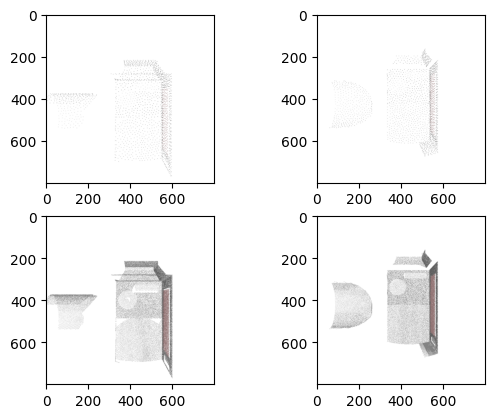

In [6]:
import visu.utils
import importlib
importlib.reload(visu.utils)
visu.utils.show_datasets_pair(root_dir, dataset=dataset_train, i=3, roted=True)

10239


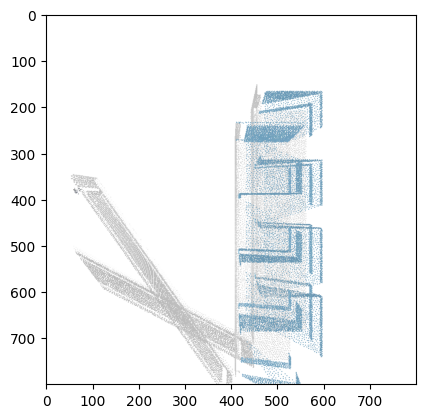

In [12]:
import visu.utils
import importlib
importlib.reload(visu.utils)
i = random.randint(0, len(dataset_train))
print(i)
name_1 = dataset_train.group_files[i][0].split('/')[-1].split('.')[0]
name_2 = dataset_train.group_files[i][1].split('/')[-1].split('.')[0]
visu.utils.show_merged_pair(root_dir, name_1, name_2)

In [8]:
import visu.visu as visu
for dataset in [dataset_train, dataset_test_inter, dataset_test_intra]:
    model.eval()
    i = random.randint(0, len(dataset))
    print(i)
    inputs = dataset[i]
    dir_name = {
        dataset_train: root_dir,
        dataset_test_inter: test_inter_dir,
        dataset_test_intra: test_intra_dir
    }
    log_name = {
        dataset_train: "train",
        dataset_test_inter: "inter",
        dataset_test_intra: "intra"
    }
    name_1 = dataset.group_files[i][0].split('/')[-1].split('.')[0]
    name_2 = dataset.group_files[i][1].split('/')[-1].split('.')[0]
    with torch.no_grad():
        (p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2) = model([inputs])
    rot_1_pred = vectors_to_rotation_matrix(p_green_R1, p_red_R1)
    rot_2_pred = vectors_to_rotation_matrix(p_green_R2, p_red_R2)
    visu.visualize_gapartnet(f"./log_dir/GPV_test/visu/{log_name[dataset]}", dir_name[dataset], None, ['pc', 'world_gt', 'world_pred'], name_1, rot_pred = rot_1_pred.detach().squeeze(0).cpu(), five=False)
    visu.visualize_gapartnet(f"./log_dir/GPV_test/visu/{log_name[dataset]}", dir_name[dataset], None, ['pc', 'world_gt', 'world_pred'], name_2, rot_pred = rot_2_pred.detach().squeeze(0).cpu(), five=False)

16447
883
300


In [20]:
for pc_pairs in dataloader_train:
    sym1, sym2 = get_sym_from_input(pc_pairs)
    if (sym1 != 0).any() or (sym2 != 0).any():
        print(sym1)
        print(sym2)
        break
    

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x750a829f35b0>
Traceback (most recent call last):
  File "/home/zhangran/miniconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/zhangran/miniconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/zhangran/miniconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


In [16]:
def get_sym_info(c, mug_handle=1):
    #  sym_info  c0 : face classfication  c1, c2, c3:Three view symmetry, correspond to xy, xz, yz respectively
    # c0: 0 no symmetry 1 axis symmetry 2 two reflection planes 3 unimplemented type
    #  Y axis points upwards, x axis pass through the handle, z axis otherwise
    #
    # for specific defination, see sketch_loss
    if c == 'bottle':
        sym = np.array([1, 1, 0, 1], dtype=np.int)
    elif c == 'bowl':
        sym = np.array([1, 1, 0, 1], dtype=np.int)
    elif c == 'camera':
        sym = np.array([0, 0, 0, 0], dtype=np.int)
    elif c == 'can':
        sym = np.array([1, 1, 1, 1], dtype=np.int)
    elif c == 'laptop':
        sym = np.array([0, 1, 0, 0], dtype=np.int)
    elif c == 'mug' and mug_handle == 1:
        sym = np.array([0, 1, 0, 0], dtype=np.int)  # for mug, we currently mark it as no symmetry
    elif c == 'mug' and mug_handle == 0:
        sym = np.array([1, 0, 0, 0], dtype=np.int)
    else:
        sym = np.array([0, 0, 0, 0], dtype=np.int)
    return sym

def cal_geo_loss_face(points, p_rot_g, f_rot_g, p_rot_r, f_rot_r, p_t, p_s, mean_shape, sym):
    bs = points.shape[0]
    res = 0.0
    re_s = p_s + mean_shape
    for i in range(bs):
        # reproj
        # cal R
        new_y, new_x = get_vertical_rot_vec(f_rot_g[i], f_rot_r[i], p_rot_g[i, ...], p_rot_r[i, ...])
        p_R = get_rot_mat_y_first(new_y.view(1, -1), new_x.view(1, -1))[0]  # 3 x 3
        points_re = torch.mm(p_R.permute(1, 0), (points[i, ...] - p_t[i, ...].view(1, -1)).permute(1, 0))
        points_re = points_re.permute(1, 0)  # n x 3
        # points_reaugment according to the sym
        if sym[i, 1] > 0:  # xy reflection
            points_re_z = torch.cat([points_re[:, :2], -points_re[:, 2:]], dim=-1)
            points_re = torch.cat([points_re, points_re_z], dim=0)
        if sym[i, 2] > 0:  # xz reflection
            points_re_z = torch.cat([points_re[:, 0].view(-1, 1), -points_re[:, 1].view(-1, 1),
                                        points_re[:, 2].view(-1, 1)], dim=-1)
            points_re = torch.cat([points_re, points_re_z], dim=0)
        if sym[i, 3] > 0:  # yz reflection
            points_re_z = torch.cat([-points_re[:, 0].view(-1, 1), points_re[:, 1:]], dim=-1)
            points_re = torch.cat([points_re, points_re_z], dim=0)

        # for six faces
        # face 1
        residuals = torch.abs(re_s[i, 1] / 2 - points_re[:, 1])
        res_yplus = torch.min(residuals)
        # face 2
        residuals = torch.abs(re_s[i, 0] / 2 - points_re[:, 0])
        res_xplus = torch.min(residuals)
        # face 3
        residuals = torch.abs(re_s[i, 2] / 2 - points_re[:, 2])
        res_zplus = torch.min(residuals)
        # face 4
        residuals = torch.abs(points_re[:, 0] + re_s[i, 0] / 2)
        res_xminus = torch.min(residuals)
        # face 5
        residuals = torch.abs(points_re[:, 2] + re_s[i, 2] / 2)
        res_zminus = torch.min(residuals)
        # face 6
        residuals = torch.abs(points_re[:, 1] + re_s[i, 1] / 2)
        res_yminus = torch.min(residuals)

        res += res_xplus
        res += res_yplus
        res += res_zplus
        res += res_xminus
        res += res_yminus
        res += res_zminus
    res = res / 6 / bs
    return res

def prop_sym_matching_loss(self, PC, PC_re, p_g_vec, p_r_vec, p_t, gt_R, gt_t, sym):
    bs = PC.shape[0]
    points_re_cano = torch.bmm(gt_R.permute(0, 2, 1), (PC - gt_t.view(bs, 1, -1)).permute(0, 2, 1))
    points_re_cano = points_re_cano.permute(0, 2, 1)
    res_p_recon = 0.0
    res_p_rt = 0.0
    for i in range(bs):
        PC_now = PC[i, ...]
        PC_re_now = PC_re[i, ...]
        PC_re_cano = points_re_cano[i, ...]
        p_g_now = p_g_vec[i, ...]
        if sym[i, 0] == 1 and torch.sum(sym[i, 1:]) > 0:  # y axis reflection, can, bowl, bottle
            gt_re_points = torch.cat([-PC_re_cano[:, 0].view(-1, 1),
                                        PC_re_cano[:, 1].view(-1, 1),
                                        -PC_re_cano[:, 2].view(-1, 1)], dim=1)
            gt_PC = torch.mm(gt_R[i, ...], gt_re_points.T) + gt_t[i, ...].view(-1, 1)
            gt_PC = gt_PC.T    # 1028 X 3
            res_p_recon += self.loss_func(PC_re_now, gt_PC)
            # loss for p_g_now
            #p_g_now= gt_R[i, :, 1]
            p_t_now = p_t[i, ...]
            pc_t_res = PC_now - p_t_now.view(1, -1)
            vec_along_p_g = torch.mm(torch.mm(pc_t_res, p_g_now.view(-1, 1)), p_g_now.view(1, -1))  # 1028 x 3
            a_to_1_2_b = vec_along_p_g - pc_t_res
            PC_b = PC_now + 2.0 * a_to_1_2_b
            res_p_rt += self.loss_func(PC_b, PC_re_now)
        elif sym[i, 0] == 0 and sym[i, 1] == 1:  # yx reflection, laptop, mug with handle
            gt_re_points = torch.cat([PC_re_cano[:, 0].view(-1, 1),
                                        PC_re_cano[:, 1].view(-1, 1),
                                        -PC_re_cano[:, 2].view(-1, 1)], dim=1)
            gt_PC = torch.mm(gt_R[i, ...], gt_re_points.T) + gt_t[i, ...].view(-1, 1)
            gt_PC = gt_PC.T  # 1028 X 3
            res_p_recon += self.loss_func(PC_re_now, gt_PC)
            # loss for p_g_now and p_r_now
            p_r_now = p_r_vec[i, ...]
            #p_r_now = gt_R[i, :, 0]
            #p_g_now = gt_R[i, :, 1]
            p_t_now = p_t[i, ...]
            # cal plane normal
            p_z_now = torch.cross(p_r_now, p_g_now)
            p_z_now = p_z_now / (torch.norm(p_z_now) + 1e-8)
            #  please refer to https://www.zhihu.com/question/450901026
            t = -(torch.mm(p_z_now.view(1, -1), PC_now.T) - torch.dot(p_z_now, p_t_now))  # 1 x  1028
            PC_b = PC_now + 2.0 * torch.mm(p_z_now.view(-1, 1), t).T
            res_p_rt += self.loss_func(PC_b, PC_re_now)
        elif sym[i, 0] == 1 and torch.sum(sym[i, 1:]) == 0:   # mug without handle
            continue      # not calculate it
        else:       # camera
            res_p_recon += self.loss_func(PC, PC_re)
            res_p_rt += 0.0

    res_p_rt = res_p_rt / bs
    res_p_recon = res_p_recon / bs
    return res_p_recon, res_p_rt